[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ryanfobel/utility-bill-scraper/blob/main/notebooks%2Ffeatures%2Fcase_study.ipynb)

# Case study for replacing a high-efficiency natural gas water heater with an electric resistive water heater

In [1]:
%load_ext autoreload
%autoreload 2

try:
    import utility_bill_scraper
except ModuleNotFoundError:
    import subprocess
    import sys

    cmd = (
        f"{sys.executable} -m pip install --upgrade --upgrade-strategy "
        "only-if-needed "
        "git+https://github.com/ryanfobel/utility-bill-scraper.git"
    )
    subprocess.check_output(cmd, stderr=subprocess.STDOUT, shell=True).decode("utf-8")

from utility_bill_scraper import install_colab_dependencies

install_colab_dependencies(required_envs=["KWHYDRO_USER", "KWHYDRO_PASSWORD"])

%matplotlib inline

import datetime as dt
import os
import sys

from cycler import cycler
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utility_bill_scraper import LIGHT_COLORMAP
import utility_bill_scraper.canada.on.kitchener_wilmot_hydro as kwh
import utility_bill_scraper.canada.on.kitchener_utilities as ku
from utility_bill_scraper import GAS_KGCO2_PER_CUBIC_METER

# Plotting preferences
plt.rc("axes", prop_cycle=cycler("color", LIGHT_COLORMAP))
figsize = (12, 6)
bin_width = 0.9
alpha = 0.5
transparent = False
bbox_inches = "tight"
facecolor = "white"

title_size=30
ylabel_size=30
legend_size=25
font_size=25

# Load the `.env` file into the environment if it exists
load_dotenv()

MAP = {
    ku.NAME: ku.KitchenerUtilitiesAPI,
    kwh.NAME: kwh.KitchenerWilmotHydroAPI,
}

In [2]:
api = {}
updates = {}
for utility_name in MAP.keys():
    kwargs = {
        "data_path": os.getenv("DATA_PATH", os.path.join("..", "..", "..", "data")),
        "google_sa_credentials": os.getenv("GOOGLE_SA_CREDENTIALS"),
        "browser": os.getenv("BROWSER", "Firefox"),
        "headless": True,
    }
    if utility_name == "Kitchener-Wilmot Hydro":
        kwargs["user"] = os.getenv("KWHYDRO_USER")
        kwargs["password"] = os.getenv("KWHYDRO_PASSWORD")
    elif utility_name == "Kitchener Utilities":
        kwargs["user"] = os.getenv("KITCHENER_UTILITIES_USER")
        kwargs["password"] = os.getenv("KITCHENER_UTILITIES_PASSWORD")
        
    api[utility_name] = MAP[utility_name](**kwargs)
    # updates[utility_name] = api[utility_name].update(24)
    # if updates[utility_name] is not None:
    #     print(f"{ utility_name }: { len(updates[utility_name]) } statements_downloaded")

# Resample monthly data to end of month
electricity = api[kwh.NAME].history("monthly").resample('D').interpolate().resample('M').interpolate()
gas = api[ku.NAME].history("monthly").resample('D').interpolate().resample('M').interpolate()

Download file from google drive(file_id=1-IYaB4IdO6rQnNmh-Fo8DyEm5OLQCruo, local_path=/tmp/tmpwydabjsq/monthly.csv
Download file from google drive(file_id=16srVcNXMkblkPtm-j0nRk6D0iW5ieg48, local_path=/tmp/tmpgy6glidi/monthly.csv


# Calculate CO$_2$ emissions

In [3]:
electricity = api[kwh.NAME].history("monthly").resample('D').interpolate().resample('M').interpolate()
gas = api[ku.NAME].history("monthly").resample('D').interpolate().resample('M').interpolate()

gas["kgCO2"] = gas["Gas Consumption"] * GAS_KGCO2_PER_CUBIC_METER

# Carbon intensity of electricity generation in Ontario (40-77 g CO2 / kWh)
# * 40 g / kWh (https://www.neb-one.gc.ca/nrg/sttstc/lctrct/rprt/
#               2017cndrnwblpwr/ghgmssn-eng.html)
# * 77 g / kWh (https://www.conferenceboard.ca/hcp/provincial/environment/
#               low-emitting-electricity-production.aspx)
# * This is likely to go up when Pickering is closed
#   https://www.opg.com/darlington-refurbishment/Documents/IntrinsikReport_GHG_OntarioPower.pdf

carbon_intensity_kgCO2_per_kwh = 0.077
electricity["kgCO2"] = electricity["Total Consumption"] * carbon_intensity_kgCO2_per_kwh

## Monthly electricity and gas consumption

<Figure size 432x288 with 0 Axes>

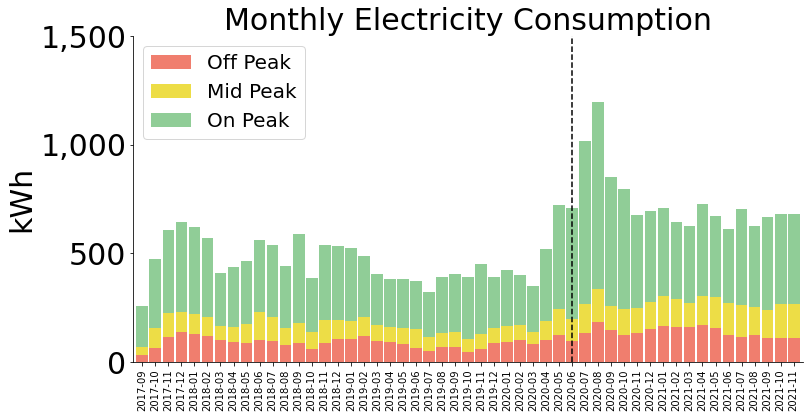

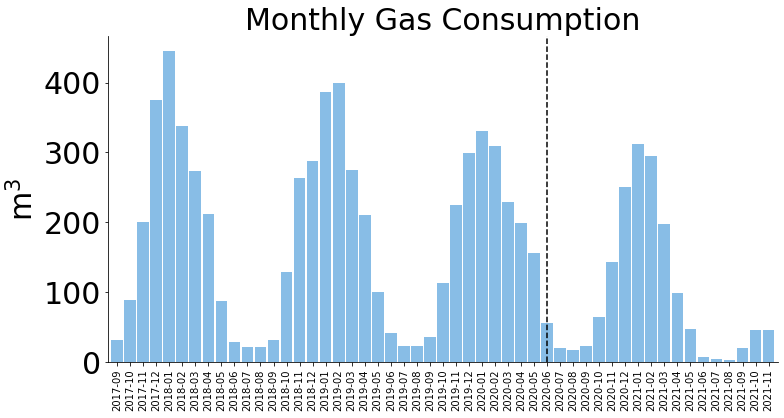

In [4]:
tco2 = pd.DataFrame()
tco2["Gas"] = gas["kgCO2"] / 1e3
tco2["Electricity"] = electricity["kgCO2"] / 1e3

cost = pd.DataFrame()
cost["Gas"] = gas["Gas Charges"]
cost["Electricity"] = electricity["Total"]

water_heater_install = [i for i, date in enumerate(tco2.index) if date.isoformat()[:7] == "2020-06"][0]

plt.figure()
electricity[["On Peak Consumption", "Mid Peak Consumption", "Off Peak Consumption"]].plot.bar(
    stacked=True,
    width=bin_width,
    color=["#F07E6E", "#EDDD46", "#90CD97"],
    figsize=figsize,
)
plt.ylim((0, None))
plt.yticks(np.arange(0, 2000, step=500),
    ["{:,}".format(tic) for tic in np.arange(0, 2000, step=500)],
    fontsize=30,
);
plt.title("Monthly Electricity Consumption", fontsize=title_size)
plt.xlabel("")
plt.ylabel("kWh", fontsize=ylabel_size)
plt.legend(["Off Peak", "Mid Peak", "On Peak", "Total"], fontsize=20, loc="upper left")
os.makedirs("images", exist_ok=True)
plt.gca().spines.top.set_visible(False)
plt.gca().spines.right.set_visible(False)
locs, labels = plt.xticks()
plt.xticks(locs, labels=[label.get_text()[:7] for label in labels]);
plt.plot([water_heater_install, water_heater_install], plt.ylim(), 'k--')
plt.savefig(
    os.path.join("images", "monthly_electricity_consumption.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

plt.figure()
gas["Gas Consumption"].plot.bar(
    width=bin_width,
    figsize=figsize,
)
plt.ylim((0, None))
plt.title("Monthly Gas Consumption", fontsize=title_size)
plt.ylabel("m$^3$", fontsize=ylabel_size)
os.makedirs("images", exist_ok=True)
plt.yticks(np.arange(0, 500, step=100),
    ["{:,}".format(tic) for tic in np.arange(0, 500, step=100)],
    fontsize=30,
);
plt.xlabel("")
plt.plot([water_heater_install, water_heater_install], plt.ylim(), 'k--');
plt.gca().spines.top.set_visible(False)
plt.gca().spines.right.set_visible(False)
locs, labels = plt.xticks()
plt.xticks(locs, labels=[label.get_text()[:7] for label in labels])
plt.savefig(
    os.path.join("images", "monthly_gas_consumption.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)


## Monthly emissions

In [ ]:
tco2 = pd.DataFrame()
tco2["Gas"] = gas["kgCO2"] / 1e3
tco2["Electricity"] = electricity["kgCO2"] / 1e3

cost = pd.DataFrame()
cost["Gas"] = gas["Gas Charges"]
cost["Electricity"] = electricity["Total"]

cost.plot.bar(
    stacked=True,
    color=["#8c8c8c", "#90cd97"],
    width=bin_width,
    fontsize=11,
    figsize=figsize,
    legend=None,
)
xlocs, xlabels = plt.xticks()
plt.xticks(xlocs, labels=[label.get_text()[:7] for label in xlabels]);
plt.plot([water_heater_install, water_heater_install], plt.ylim(), 'k--');
plt.title("Monthly operating cost", fontsize=title_size)
plt.xlabel("")
#plt.legend(bbox_to_anchor=(1, 1.04), fontsize=25)
plt.yticks(np.arange(0, 300, step=100),
    [f"${ tic }" for tic in np.arange(0, 300, step=100)],
    fontsize=30,
);
plt.ylim((0, 250))
plt.gca().spines.top.set_visible(False)
plt.gca().spines.right.set_visible(False)
plt.savefig(
    os.path.join("images", "monthly_operating_cost.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)


tco2.plot.bar(
    stacked=True,
    color=["#8c8c8c", "#90cd97"],
    width=bin_width,
    fontsize=30,
    ylabel="tCO$_2$e",
    figsize=figsize,
    legend=None,
)
plt.title("Monthly CO$_2$ emissions", fontsize=title_size)
plt.ylabel("Tons", fontsize=30)
xlocs, xlabels = plt.xticks()
plt.xticks(xlocs,
    labels=[label.get_text()[:7] for label in xlabels],
    fontsize=11,
);
plt.xlabel("")
plt.gca().spines.top.set_visible(False)
plt.gca().spines.right.set_visible(False)
plt.plot([water_heater_install, water_heater_install], plt.ylim(), 'k--')
plt.savefig(
    os.path.join("images", "monthly_emissions.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

In [ ]:
tco2["year"] = [date.year for date in tco2.index]
cost["year"] = [date.year for date in cost.index]

tco2[tco2["year"] > 2017].groupby("year").sum().plot.bar(
    stacked=True,
    fontsize=font_size,
    color=["#8c8c8c", "#90cd97"],
    width=bin_width,
    figsize=figsize,
    legend=None,
)
plt.title("Annual CO$_2$e emissions", fontsize=title_size)
plt.ylabel("Tons", fontsize=ylabel_size)
os.makedirs("images", exist_ok=True)
plt.xlabel("")
#plt.legend(bbox_to_anchor=(1, 1.04), fontsize=legend_size)
plt.xticks(rotation=0)
plt.gca().spines.top.set_visible(False)
plt.gca().spines.right.set_visible(False)
plt.savefig(
    os.path.join("images", "annual_co2_emissions.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

cost[cost["year"] > 2017].groupby("year").sum().plot.bar(
    stacked=True,
    fontsize=font_size,
    color=["#8c8c8c", "#90cd97"],
    width=bin_width,
    figsize=figsize,
    legend=None,
)
plt.title("Annual operating costs", fontsize=title_size)
os.makedirs("images", exist_ok=True)
plt.xlabel("")
#plt.legend(bbox_to_anchor=(1, 1.04), fontsize=legend_size)
plt.xticks(rotation=0)
plt.yticks(np.arange(0, 2500, step=500),
    ["${:,}".format(tic) for tic in np.arange(0, 2500, step=500)],
    fontsize=30,
);
plt.gca().spines.top.set_visible(False)
plt.gca().spines.right.set_visible(False)
plt.savefig(
    os.path.join("images", "annual_operating_costs.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

## Comparing CO$_2$ emissions and cost for 12 months before and after

In [ ]:
import arrow
water_heater_install_date = "2020-06-16"
after_idx = [i for i, date in enumerate(tco2.index) if date > arrow.get(water_heater_install_date).naive]
before_idx = [i for i, date in enumerate(tco2.index) if date < arrow.get(water_heater_install_date).naive]

In [ ]:
comparison = tco2.iloc[before_idx[-12:] + after_idx[:12]].copy()
comparison["Total"] = comparison["Gas"] + comparison["Electricity"]
comparison["Period"] = ["12-months\nbefore"]*12 + ["12-months\nafter"]*12
comparison.drop(columns="year", inplace=True)
comparison.groupby("Period").sum().sort_index(ascending=False)[["Gas", "Electricity"]].plot.bar(
    width=.98,
    fontsize=30,
    stacked=True,
    color=["#8c8c8c", "#90cd97"],
    figsize=(10, 6),
);
plt.xticks(rotation=0)
plt.xlabel("")
plt.legend(bbox_to_anchor=(1, 1.04), fontsize=25)
plt.title("CO$_2$ emissions", fontsize=50)
plt.gca().spines.top.set_visible(False)
plt.gca().spines.right.set_visible(False)

change_tco2 = np.diff(comparison.groupby("Period").sum()["Total"].sort_index(ascending=False))[0]
print("Change in CO2: %.1ft/year (%.0f%%)" % (change_tco2,
    (100 * change_tco2 / comparison.iloc[:12].sum()['Total']))
)
plt.yticks(range(5))
plt.ylabel("Tons", fontsize=25)
plt.savefig(
    os.path.join("images", "compare_emissions.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

In [ ]:
comparison = cost.iloc[before_idx[-12:] + after_idx[:12]].copy()
comparison["Total"] = comparison["Gas"] + comparison["Electricity"]
comparison["Period"] = ["12-months\nbefore"]*12 + ["12-months\nafter"]*12
comparison.drop(columns="year", inplace=True)
comparison.groupby("Period").sum().sort_index(ascending=False)[["Gas", "Electricity"]].plot.bar(
    width=.98,
    stacked=True,
    color=["#8c8c8c", "#90cd97"],
    fontsize=30,
    figsize=(10, 6),
    legend=None,
)
plt.xticks(rotation=0)
#plt.legend(bbox_to_anchor=(1, 1.04), fontsize=25)
plt.title("Operating cost", fontsize=50)
plt.xlabel("")
plt.yticks(np.arange(0, 2500, step=500),
    ["${:,}".format(tic) for tic in np.arange(0, 2500, step=500)],
    fontsize=30,
);
plt.gca().spines.top.set_visible(False)
plt.gca().spines.right.set_visible(False)

change_cost = np.diff(comparison.groupby("Period").sum()["Total"].sort_index(ascending=False))[0]
print("Change in cost: $%.2f/year (%.0f%%)" % (change_cost,
    (100 * change_cost / comparison.iloc[:12].sum()['Total']))
)
plt.savefig(
    os.path.join("images", "compare_operating_cost.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)